10/8 - 10/10/2023

The first part of my Au23 data science capstone was coming with a possible project topic. The topic I thought of was identifying the areas (neighborhoods), times (hours of day, months, years), and weather conditions that were most likely to have/cause fires, using Everett WA Fire Department call data and NOAA Snohomish County WA Weather Data. I chose Everett WA because my dad was a firefighter/paramedic for the Everett Fire Department for 27 years, so I've always been invested in the goings-on of that city. My eventual capstone group ended up choosing the topic of the effect of a research paper's presentational attributes on its influence, but I put so much thought into this project that I wanted to do it independently.

In [41]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

filename = 'Fire_911_Unit_Dispatches.csv'
fireData = pd.read_csv(filename)
# Remove duplicates, since there can be multiple calls per event
fireData = fireData.drop_duplicates(subset=["CallID"])
fireData.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 190217 entries, 0 to 393297
Data columns (total 22 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   StartDatetime               190217 non-null  object 
 1   CallID                      190217 non-null  int64  
 2   Incident #                  190186 non-null  object 
 3   CallCategory                176697 non-null  object 
 4   FinalCallType               190217 non-null  object 
 5   FinalTypeDescription        190217 non-null  object 
 6   FinalCallPriority           176922 non-null  object 
 7   LocationBy100Block          190217 non-null  object 
 8   CallLocationFireDepartment  190217 non-null  object 
 9   Neighborhood                190217 non-null  object 
 10  Station                     190165 non-null  object 
 11  Quadrant                    190209 non-null  object 
 12  GeomCoordinate              190215 non-null  object 
 13  RespondingFire

In [42]:
# removing attributes that I don't plan on using
fireData = fireData.drop("Incident #", axis=1)
fireData = fireData.drop("FinalCallPriority", axis=1)
fireData = fireData.drop("LocationBy100Block", axis=1)
fireData = fireData.drop("CallLocationFireDepartment", axis=1)
fireData = fireData.drop("Station", axis=1)
fireData = fireData.drop("Quadrant", axis=1)
fireData = fireData.drop("RespondingFireDepartment", axis=1)
fireData = fireData.drop("UnitNumber", axis=1)
fireData = fireData.drop("ArrivalOrder", axis=1)
fireData = fireData.drop("CallFilter", axis=1)
fireData = fireData.drop("IncidentFilter", axis=1)

In [43]:
# Original code:
# for index, row in fireData.iterrows():
#     row["StartDatetime"] = datetime.datetime.strptime(row["StartDatetime"], '%m/%d/%Y %I:%M:%S %p').date() 
#     if row["StartDatetime"].year < 2017:
#         fireData.drop(index)
#     if row["CallCategory"] != "FIRE":
#         fireData.drop(index)

# Optimized code, via ChatGPT 3.5 (I haven't worked too extensively with Pandas, so I didn't know how to optimize):

# Convert the "StartDatetime" column to datetime format
fireData["StartDatetime"] = pd.to_datetime(fireData["StartDatetime"], format='%m/%d/%Y %I:%M:%S %p')
# Keep rows 2016 or after, since my weather dataset is 2016-2023
# Only keep rows that relate to fire calls (excluding fire alarm related calls, whose acronyms begin with FA)
fireData = fireData[(fireData["StartDatetime"].dt.year >= 2016) & (fireData["CallCategory"] == "FIRE") & (fireData["FinalCallType"] != "FAC") & (fireData["FinalCallType"] != "FAR") & (fireData["FinalCallType"] != "FAS")]
# Remove the time portion by converting the datetime to date
fireData["StartDatetime"] = fireData["StartDatetime"].dt.strftime('%m/%d/%Y')
# Sort by date
fireData = fireData.sort_values(by="StartDatetime", axis=0)
# Reset index if needed
fireData.reset_index(drop=True, inplace=True)
# Drop call category because it's not necessary anymore
fireData = fireData.drop("CallCategory", axis=1)

In [44]:
print(fireData["StartDatetime"][6])

01/01/2017


In [45]:
fireData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10543 entries, 0 to 10542
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   StartDatetime         10543 non-null  object
 1   CallID                10543 non-null  int64 
 2   FinalCallType         10543 non-null  object
 3   FinalTypeDescription  10543 non-null  object
 4   Neighborhood          10543 non-null  object
 5   GeomCoordinate        10543 non-null  object
 6   StartDateYear         10543 non-null  int64 
 7   StartDateMonth        10543 non-null  object
 8   StartDateDay          10543 non-null  object
 9   StartDateHour         10543 non-null  int64 
dtypes: int64(3), object(7)
memory usage: 823.8+ KB


In [46]:
# split Geomcoordinate into latitude and longitude
# which will make plotting easier
lat = np.array([])
lon = np.array([])
for index, row in fireData.iterrows():
    str = row["GeomCoordinate"]
    str = str[7:-1]
    strs = str.split(" ")
    #print(strs)
    lat = np.append(lat, strs[0])
    lon = np.append(lon, strs[1])
fireData["Latitude"] = lat
fireData["Longitude"] = lon
fireData = fireData.drop("GeomCoordinate", axis=1)

In [47]:
fireData.head()

,StartDatetime,CallID,FinalCallType,FinalTypeDescription,Neighborhood,StartDateYear,StartDateMonth,StartDateDay,StartDateHour,Latitude,Longitude
0,01/01/2016,287281,FR,FIRE RESIDENTIAL FULL RESPONSE,SOUTH FOREST PARK,2016,JANUARY,FRIDAY,10,-122.217483,47.94943199999999
1,01/01/2016,286837,COA,CARBON MONOXIDE ALARM,RIVERSIDE,2016,JANUARY,FRIDAY,4,-122.187972,47.988284
2,01/01/2016,286872,GLO,GAS LEAK OUTSIDE STRUCTURE,SILVER LAKE,2016,JANUARY,FRIDAY,5,-122.206678,47.887231
3,01/01/2016,287623,FC,FIRE COMMERCIAL RESPONSE,WESTMONT,2016,JANUARY,FRIDAY,14,-122.234563,47.915308
4,01/01/2016,288136,FS,FIRE SINGLE ENGINE RESPONSE,SILVER LAKE,2016,JANUARY,FRIDAY,18,-122.206678,47.887231


Not Assigned                     2160
PORT GARDNER                     1325
HOLLY                             661
PINEHURST                         623
RIVERSIDE                         621
WESTMONT                          612
TWIN CREEKS                       571
BAYSIDE                           561
SILVER LAKE                       548
DELTA                             519
CASCADE VIEW                      477
NORTHWEST EVERETT                 368
GLACIER VIEW                      332
VIEW RIDGE-MADISON                261
EVERGREEN                         234
SOUTH FOREST PARK                 212
LOWELL                            161
HARBORVIEW-SEAHURST-GLENHAVEN     125
BOULEVARD BLUFFS                  119
VALLEY VIEW                        53
Name: Neighborhood, dtype: int64


<AxesSubplot:title={'center':'Number of 2016-2023 Fires Per Neighborhood'}, xlabel='Everett Neighborhood', ylabel='Number of Fires from 2016-2023'>

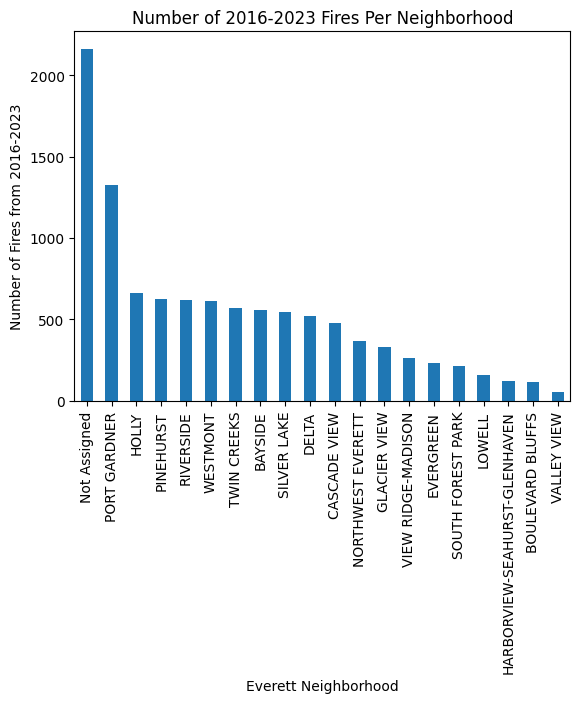

In [48]:
print(fireData['Neighborhood'].value_counts(sort=True))
fireData['Neighborhood'].value_counts(sort=True).plot.bar(xlabel="Everett Neighborhood", ylabel="Number of Fires from 2016-2023", title="Number of 2016-2023 Fires Per Neighborhood")

2016    1155
2017    1302
2018    1124
2019    1164
2020    1280
2022    1747
2023    1248
2021    1523
Name: StartDateYear, dtype: int64


<AxesSubplot:title={'center':'Number of Fires Per Year'}, xlabel='Years', ylabel='Number of Fires'>

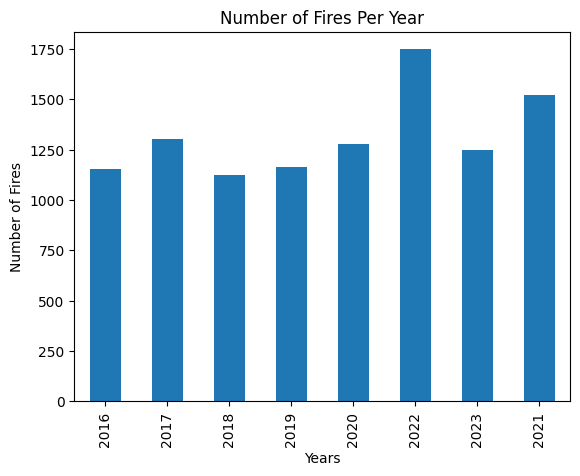

In [49]:
print(fireData['StartDateYear'].value_counts(sort=False))
fireData['StartDateYear'].value_counts(sort=False).plot.bar(xlabel="Years", ylabel="Number of Fires", title="Number of Fires Per Year")

JANUARY       851
FEBRUARY      719
MARCH         795
APRIL         750
MAY           860
JUNE          935
JULY         1478
AUGUST       1308
SEPTEMBER     757
OCTOBER       702
NOVEMBER      662
DECEMBER      726
Name: StartDateMonth, dtype: int64


<AxesSubplot:title={'center':'Number of Fires During Each Month from 2016-2023'}, xlabel='Months', ylabel='Number of Fires from 2016-2023'>

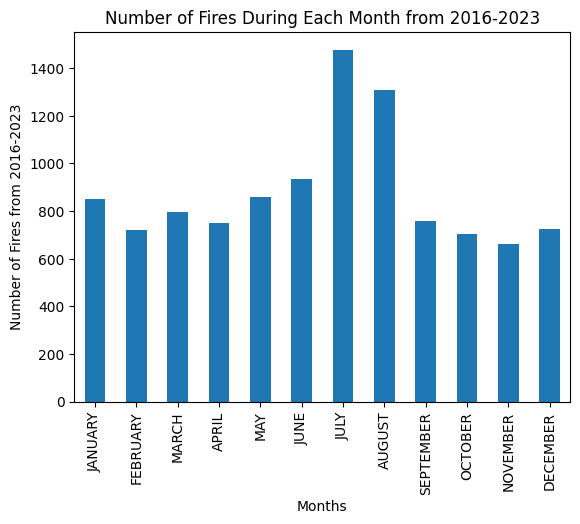

In [50]:
print(fireData['StartDateMonth'].value_counts(sort=False))
fireData['StartDateMonth'].value_counts(sort=False).plot.bar(xlabel="Months", ylabel="Number of Fires from 2016-2023", title="Number of Fires During Each Month from 2016-2023")

SUNDAY       1527
MONDAY       1523
TUESDAY      1449
WEDNESDAY    1526
THURSDAY     1437
FRIDAY       1545
SATURDAY     1536
Name: StartDateDay, dtype: int64


<AxesSubplot:title={'center':'Number of Fires During Each Day from 2016-2023'}, xlabel='Days', ylabel='Number of Fires from 2016-2023'>

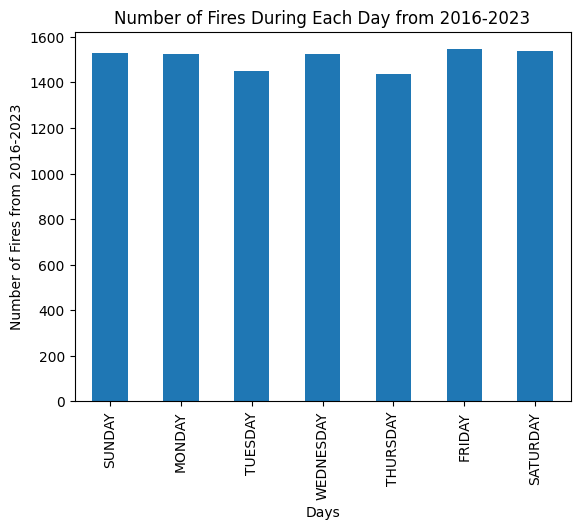

In [51]:
# code I got from Stack Overflow to display days in correct order
# https://stackoverflow.com/questions/22635110/sorting-the-order-of-bars-in-pandas-matplotlib-bar-plots
day_array = ["SUNDAY", "MONDAY", "TUESDAY", "WEDNESDAY", "THURSDAY", "FRIDAY", "SATURDAY"]
mapping = {day: i for i, day in enumerate(day_array)}
key = fireData['StartDateDay'].map(mapping)
fireDataGraph = fireData.iloc[key.argsort()]
print(fireDataGraph['StartDateDay'].value_counts(sort=False))
fireDataGraph['StartDateDay'].value_counts(sort=False).plot.bar(xlabel="Days", ylabel="Number of Fires from 2016-2023", title="Number of Fires During Each Day from 2016-2023")

0     359
1     303
2     241
3     229
4     266
5     292
6     314
7     357
8     407
9     368
10    423
11    462
12    472
13    494
14    505
15    582
16    611
17    628
18    688
19    575
20    547
21    529
22    476
23    415
Name: StartDateHour, dtype: int64


<AxesSubplot:title={'center':'Number of Fires During Each Hour from 2016-2023'}, xlabel='Hours (Miltary Time)', ylabel='Number of Fires from 2016-2023'>

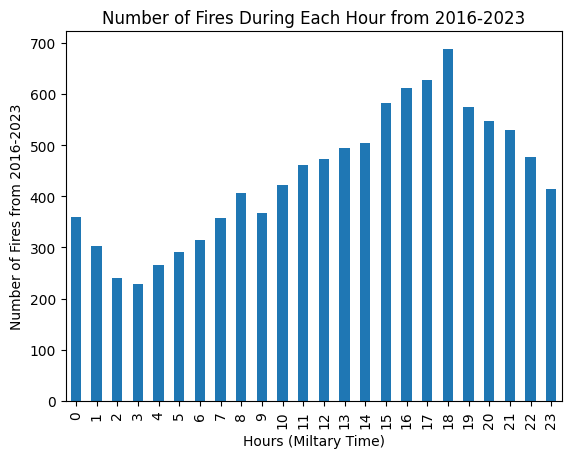

In [52]:
# used same code from above to display hours in correct order
mapping = {day: i for i, day in enumerate(np.arange(0, 23+1))}
key = fireData['StartDateHour'].map(mapping)
fireDataGraph2 = fireData.iloc[key.argsort()]
print(fireDataGraph2['StartDateHour'].value_counts(sort=False))
fireDataGraph2['StartDateHour'].value_counts(sort=False).plot.bar(xlabel="Hours (Miltary Time)", ylabel="Number of Fires from 2016-2023", title="Number of Fires During Each Hour from 2016-2023")

FIRE SINGLE ENGINE RESPONSE           5451
FIRE COMMERCIAL RESPONSE              1157
FIRE RESIDENTIAL FULL RESPONSE         840
CARBON MONOXIDE ALARM                  605
FIRE TYPE UNKNOWN                      592
FIRE BRUSH, GRASS OR WILDLAND FIRE     535
GAS LEAK INSIDE STRUCTURE              332
FIRE RESIDENTIAL CONFIRMED             320
FIRE COMMERCIAL CONFIRMED              272
GAS LEAK OUTSIDE STRUCTURE             263
HAZMAT                                 123
GENERIC AID/EMS                         20
MUTUAL AID FIRE                         14
SERVICE CALL                             6
AIRCRAFT STANDBY                         5
FIRE INVESTIGATION                       3
FIRE ALARM COMMERCIAL                    2
UPGRADED MEDIC RESPONSE                  1
FIRE FERRY BOAT                          1
GENERIC FIRE CALL                        1
Name: FinalTypeDescription, dtype: int64


<AxesSubplot:title={'center':'Types of Fires from 2016-2023'}, xlabel='Fire Type', ylabel='Number of Fires from 2016-2023'>

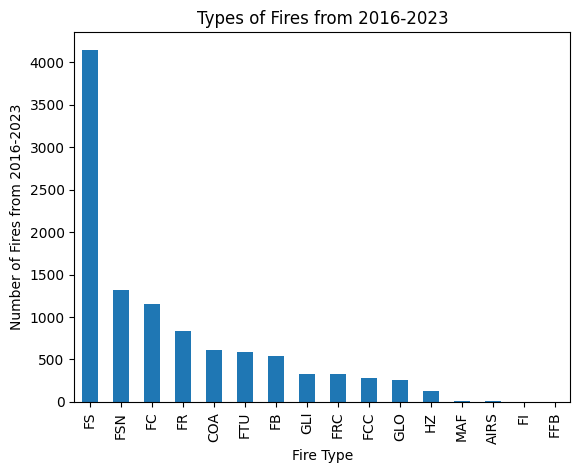

In [53]:
print(fireData['FinalTypeDescription'].value_counts(sort=True))
fireData['FinalCallType'].value_counts(sort=True).plot.bar(xlabel="Fire Type", ylabel="Number of Fires from 2016-2023", title="Types of Fires from 2016-2023")

Note for the above graph: FS and FSN are both under "FIRE SINGLE ENGINE RESPONSE"

Funnily enough, this was supposed to just be the notebook where I prune and tune both the fire call and weather data, but since it's so easy to make histograms with dataframes and counts, I ended doing about half of my data analysis just in this notebook. I'll have to do the weather dataset tuning in another notebook so this one doesn't get too long.

My next steps are:
- Pruning and editing the weather dataset in Python
- Joining both datasets in SQL
- Graphing fire data alongside weather data (possibly in Vega Lite if MatPlotLib proves to be annoying)
- Plotting fire data geographically in Vega Lite or Tableau

In [54]:
# fireData.to_csv(r'PrunedFireCallData.csv', index=False) #export pruned and edited data for future use